# Inferential Analysis

Q<sub>1</sub>: State assumptions about your data<br/>
A<sub>1</sub>: We separated our data into healthy people and people with a single disorder (bu no other disorders) so we could examine if each disorder affect brain activity. We chose to examine healthy people and those with anxiety disorders, denoted as group A and group B respectively.

We use deltas of brain measurements (concentration values - baseline values) to represent physical properties of group A and group B.

We assume group A and group B are independent, and that the samples of group A and group B are representative of the greater population of healthy people and those with anxiety disorders. We do not assume either group necessarily follow a normal distribution.

In [2]:
# Let's read the data_file into memory
spect_data = data.frame(read.csv("/home/srinivas/Git-Projects/spect-team/Data/Data_Adults_1.csv"))

# Drop NAs
spect_data = na.omit(spect_data)

# Extract the baseline and Concentration Values
interesting_baseline_column_start = which(colnames(spect_data) == "Baseline_Amygdala_L")
interesting_baseline_column_end = which(colnames(spect_data) == "Baseline_Vermis_9")
interesting_concentration_column_start = which(colnames(spect_data) == "Concentration_Amygdala_L")
interesting_concentration_column_end = which(colnames(spect_data) == "Concentration_Vermis_9")
baseline_values = spect_data[interesting_baseline_column_start : interesting_baseline_column_end]
concentration_values = spect_data[interesting_concentration_column_start : interesting_concentration_column_end]

# Prefix the Patient Id to make them uniquely recongizable
b_vals = cbind(spect_data["Patient_ID"], baseline_values)
c_vals = cbind(spect_data["Patient_ID"], concentration_values)

# Let us also compute the deltas in the blood flow
delta_values = concentration_values - baseline_values
deltas = cbind(spect_data["Patient_ID"], delta_values)

#deltas[1:4, 1:4]

In [3]:
healthy_patients = data.frame(read.csv("/home/srinivas/Git-Projects/spect-team/Data/healthy_IDs.csv"))
anxious_patients = data.frame(read.csv("/home/srinivas/Git-Projects/spect-team/Data/AnxietyDisorder_IDs.csv"))
print(nrow(healthy_patients))
print(nrow(anxious_patients))

[1] 50
[1] 15


In [4]:
# Let us perform a cartesian join of the two data frames
healthy = deltas[deltas$Patient_ID %in% healthy_patients$Patient_ID,]
anxious = deltas[deltas$Patient_ID %in% anxious_patients$Patient_ID,]

Q<sub>2</sub>: Formally define statistical test<br/>
A<sub>2</sub>: We define our null hypothesis as the statistical equality of the means of the two groups. The means are denoted as \mu_A and \mu_B respectively. We accept the null hypothesis when p-value is larger than 0.05.

H<sub>A</sub>: *A != B*

H<sub>O</sub>: *A = B*

Q<sub>3</sub>: Provide algorithm for implementing test

In [5]:
p_vector = 0
# Lets loop over the columns
for (i in names(healthy[-1])) {
    col1 = as.vector(healthy[,i])
    col2 = as.vector(anxious[,i])
    ans = wilcox.test(col1, col2, alternative="two.sided")
    p_vector = cbind(p_vector, ans[3])
}
names(p_vector) = names(healthy)
write.csv(healthy, "healthy.csv")
write.csv(anxious, "anxious.csv")
write.csv(rbind(names(healthy),p_vector), "pvals.csv")

Q<sub>4</sub>. sample data from an element of the null model, and plot power vs. n (power should be at alpha) && Q<sub>5</sub>: sample data from an element of the alternative model, and plot power vs. n (power should increase to 1)<br/>
A<sub>4,5</sub>: Look below for the power plot and the relevant code

[1] 24
[1] 24


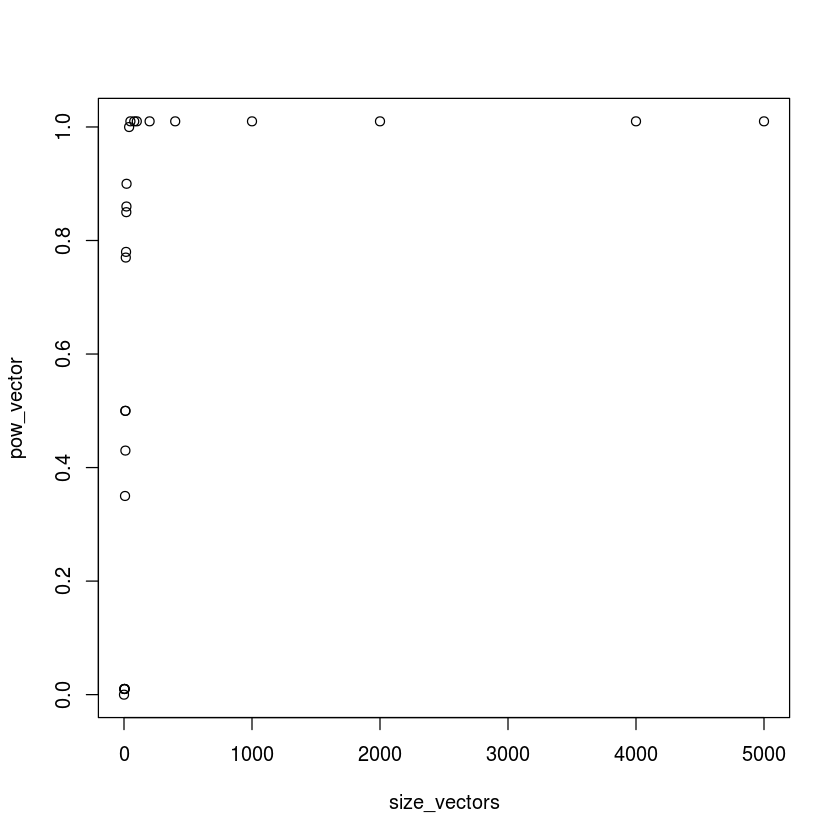

In [41]:
options(warn=-1) #The R thug life
gen_samples = function(vec, samples_needed) {
    lower = quantile(vec)[2]
    upper = quantile(vec)[4]
    samples = sample(lower:upper, samples_needed, replace=TRUE)
    return(samples)
}
healthy_cerebelum = healthy["Concentration_Cerebelum_7b_L"]
anxious_cerebelum = anxious["Concentration_Cerebelum_7b_L"]
alpha = 0.05 # for want of a better type 1 error
size_vectors = c(2, 3, 4, 6, 8, 10, 11, 12, 14, 16, 18, 19, 20, 40, 50, 80, 100, 200, 400, 1000, 2000, 4000, 5000)
iterations = 100
pow_vector = 0
for (s in size_vectors) {
    pvector = 0
    for (i in 1:iterations) {
        t = 5
        healthy_samples = gen_samples(healthy_cerebelum[,1], s/2)
        anxious_samples = gen_samples(anxious_cerebelum[,1], s/2)
        pvector = cbind(pvector, wilcox.test(healthy_samples, anxious_samples,alternative="two.sided")[3])
    }
    pow_vector = cbind(pow_vector, sum(pvector < alpha)/iterations)
}
size_vectors = c(0, size_vectors)
print(length(pow_vector))
print(length(size_vectors))
plot(size_vectors, pow_vector)


** As you can see the power grows very high with just a small increase in the sample size**

Q<sub>6</sub>: compute p-value on your real data<br/>
A<sub>6</sub>: Since the p-value for Cerebellum 7b = .02 < 0.05, we can interpret the result as the inequality of the means of group A and group B. In other words, healthy people and people with anxiety disorders come from distributions with different mean values for change in left cerebellum 7b activity between baseline and concentration values.

Q<sub>7</sub>: Explain the degree to which you believe the result and why<br/>
A<sub>7</sub>: We must be aware that the result is based on a relatively small sample size (only 15 samples). We considered comparing people with only brain trauma, which had a larger sample size (36 samples), but decided to use anxiety disorders as group B because we do not know what part of the brain was affected during the trauma, and thus what delta values would be affected from the disorder or the trauma itself. We do know that people with anxiety disorders have abnormal blood flow in the basal ganglia (http://www.amenclinics.com/the-science/spect-gallery/anxiety/), which is responsible for movement and coordination, just as is the cerebellum. Because the Wilcoxon-Mann-Whitney test is more robust, it is less likely to falsely report significance than would be the t-test. Thus, we can be fairly certain our results reflect a true difference in delta values for healthy people and those with anxiety disorders.